# Тематическая классификация длинных текстов - TFIDF и LogReg

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [3]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [4]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


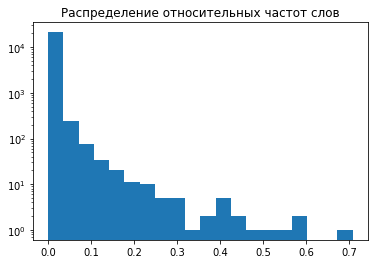

In [5]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [6]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


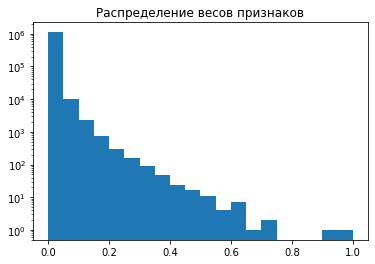

In [7]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [8]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


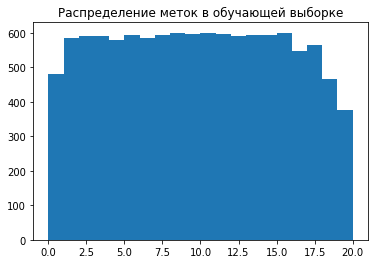

In [9]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

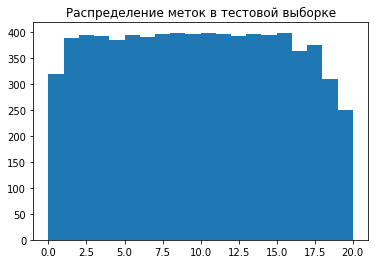

In [10]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [11]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [12]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 3.98 сек
Среднее значение функции потерь на обучении 2.2252561332142284
Среднее значение функции потерь на валидации 2.1137034347501853
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.87 сек
Среднее значение функции потерь на обучении 0.9165906374905742
Среднее значение функции потерь на валидации 1.6821972778287984
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 1.88 сек
Среднее значение функции потерь на обучении 0.46601709134161134
Среднее значение функции потерь на валидации 1.4643919311337552
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 1.88 сек
Среднее значение функции потерь на обучении 0.2836361686557026
Среднее значение функции потерь на валидации 1.3450390198978328
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 1.88 сек
Среднее значение функции потерь на обучении 0.19072450440650607
Среднее значение функции потерь на валидации 1.2602434024467306
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.04 сек
Среднее значение функции 

## Оценка качества

In [13]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████████████████████████████████████████████████████████████████████| 354/353.5625 [00:01<00:00, 221.34it/s]


Среднее значение функции потерь на обучении 0.0022322239819914103
Доля верных ответов 0.9994696835778681



236it [00:01, 221.80it/s]                                                                                              

Среднее значение функции потерь на валидации 0.9289429783821106
Доля верных ответов 0.76805629314923


# Альтернативная реализация на scikit-learn

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [24]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']).long())
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']).long())
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918552406
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582314655
Доля верных ответов 0.8190387679235263


# Bigram PMI

In [1]:
import re
from collections import defaultdict
from random import sample, shuffle

import numpy as np
from tqdm import tqdm

from nltk.corpus import stopwords as nltk_stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import scipy.sparse

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
en_stopwords = set(nltk_stopwords.words('english'))
TOKEN_REGEX = re.compile(r'[\w\d]+')

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Train dataset size:', len(train_source['data']))
print('Test dataset size:', len(test_source['data']))
print()
print('Text sample:\n')
print(train_source['data'][0].strip())

print()
print('Text label:', train_source['target'][0])

Train dataset size: 11314
Test dataset size: 7532

Text sample:

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Text label: 7


In [4]:
class Tokenizer:
    def __init__(self, args=None,
                 tokenizing_pattern=TOKEN_REGEX, min_token_len=3, stopwords=en_stopwords):
        if args is not None:
            self.args = vars(args)
        else:
            self.args = dict(tokenizing_pattern=tokenizing_pattern,
                            min_token_len=min_token_len,
                            stopwords=stopwords)
            
    def tokenize(self, _text):
        _text = _text.lower()
        unfiltered_tokens = self.args['tokenizing_pattern'].findall(_text)
        return [token for token in unfiltered_tokens if len(token) >= self.args['min_token_len']
               and token not in self.args['stopwords']]

In [5]:
basic_tokenizer = Tokenizer()

In [6]:
class SparseFeatureDataset(Dataset):
    def __init__(self, _features, _targets):
        self.features = _features
        self.targets = _targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        _features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        _label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return (_features, _label)

In [7]:
class NewsTextDataset:
    def __init__(self,
                 train_set=train_source,
                 test_set=test_source,
                 tokenizer=basic_tokenizer,
                 batch_size=64):
        # Forming the vocabulary
        self.tokenizer = tokenizer
        self.bigram_vocab, self.bigram_pmi = self.build_bigram_vocab(train_set['data'])
        self.bigram_vocab_size = len(self.bigram_vocab)
        self.bigram_vocab = list(self.bigram_vocab)
        self.bigram2id = {bigram: _id for _id, bigram in enumerate(self.bigram_vocab)}
        self.id2bigram = {_id: bigram for _id, bigram in enumerate(self.bigram_vocab)}
        self.bigram_vocab = set(self.bigram_vocab)
        
        # Vectorizing the data and building the loader
        kwargs = self.make_kwargs()
        self.train_features = self.vectorize_data(train_set['data'])
        self.train_targets = train_set['target']
        train_set = SparseFeatureDataset(self.train_features, self.train_targets)
        self.train_loader = DataLoader(train_set, batch_size=batch_size,
                                       drop_last=True, shuffle=True, **kwargs)
        self.val_features = self.vectorize_data(test_set['data'])
        self.val_targets = test_set['target']
        val_set = SparseFeatureDataset(self.val_features, self.val_targets)
        self.val_loader = DataLoader(val_set, batch_size=batch_size,
                                     drop_last=False, shuffle=False, **kwargs)
    
    def build_bigram_vocab(self, corpus, max_size=10000):
        # Getting the whole corpus token sequence
        corpus_tokens = []
        for _text in corpus:
            corpus_tokens += self.tokenizer.tokenize(_text)
        
        # Estimating the bigrams
        bigram_finder = BigramCollocationFinder.from_words(corpus_tokens)
        bgm = BigramAssocMeasures()
        score = bgm.mi_like
        collocations = {'_'.join(bigram): pmi for bigram, pmi in 
                        bigram_finder.score_ngrams(score)}
        sorted_pmi = sorted(collocations.items(), reverse=True,
                           key=lambda _: _[1])[:min(len(collocations), max_size)]
        collocations = {_key: _value for (_key, _value) in sorted_pmi}
        bigram_set = set(collocations.keys())
        
        return bigram_set, collocations
    
    def vectorize_data(self, input_data, scale=True, eps=1e-6):
        tokenized_data = [self.tokenizer.tokenize(_text) for _text in input_data]
        sparse_data = scipy.sparse.dok_matrix((len(tokenized_data), self.bigram_vocab_size),
                                              dtype='float32')
        
        for text_idx, _text in enumerate(tokenized_data):
            for token_pos in range(len(_text) - 1):
                bigram = _text[token_pos] + '_' + _text[token_pos + 1]
                if bigram in self.bigram_vocab:
                    sparse_data[text_idx, self.bigram2id[bigram]] += 1
                    
        if scale:
            sparse_data = sparse_data.tocsc()
            sparse_data -= sparse_data.min()
            sparse_data /= (sparse_data.max() + eps)
            
        return sparse_data.tocsr()
    
    @staticmethod
    def make_kwargs():
        # TODO deal with pin_memory for custom datasets
        use_cuda = False # torch.cuda.is_available()
        kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
        return kwargs

In [8]:
class NewsClassifierModel(nn.Module):
    def __init__(self, emb_dim, num_labels, dropout_rate=0.2, norm_eps=1e-12):
        super(NewsClassifierModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.LayerNorm(emb_dim, eps=norm_eps),
            nn.Dropout(p=dropout_rate),
            nn.Linear(emb_dim, num_labels)
        )

    def forward(self, _input):
        prediction = self.classifier(_input)
        return prediction

In [9]:
class NewsClassifier:
    def __init__(self):
        self.dataset = NewsTextDataset()
        self.classifier = NewsClassifierModel(self.dataset.bigram_vocab_size,
                                        len(set(self.dataset.train_targets)))
        self.optimizer = Adam(self.classifier.parameters(), lr=0.001)
        self.criterion = F.cross_entropy
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        print("Classification meta")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Training set size:", self.dataset.train_targets.shape[0])
        print("Validation set size:", self.dataset.val_targets.shape[0])
        print("Number of unique labels:", len(set(self.dataset.train_targets)))
        print("Initial embedding dimension:", self.dataset.bigram_vocab_size)
        print("Used device:", self.device.type)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        
    def train(self, epoch_num, log_interval=10):
        self.classifier.to(self.device)
        self.classifier.train()
        
        for epoch in range(epoch_num):
            epoch_loss = []
            
            for batch, (_input, _target) in enumerate(self.dataset.train_loader):
                _input, _target = _input.to(self.device), _target.to(self.device)
                
                predicted = self.classifier(_input)
                loss = self.criterion(predicted, _target)
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
                epoch_loss.append(loss.cpu().data.numpy())
                
            if (epoch + 1) % log_interval == 0 or epoch == 0:
                mean_epoch_loss = sum(epoch_loss) / len(epoch_loss)
                _accuracy = self.evaluate()
                print("Epoch #{epoch_num}\nMean epoch loss: {mean_loss}".format(
                    epoch_num=epoch + 1, mean_loss=mean_epoch_loss))
                print("Accuracy on validation:", _accuracy)
                print()
                
    def evaluate(self):
        self.classifier.to(self.device)
        self.classifier.eval()
        predictions, targets = [], []
        
        with torch.no_grad():
            for _input, _target in self.dataset.val_loader:
                _input = _input.to(self.device)
                predicted = self.classifier(_input)
                predicted = torch.argmax(predicted, dim=-1)
                predictions.append(predicted.detach().cpu().numpy())
                targets.append(_target.cpu().numpy())
                
        predictions = np.concatenate(predictions, 0)
        targets = np.concatenate(targets, 0)
        _accuracy = accuracy_score(targets, predictions)
        
        return _accuracy

In [10]:
classifier = NewsClassifier()
classifier.train(1000, log_interval=100)

Classification meta
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training set size: 11314
Validation set size: 7532
Number of unique labels: 20
Initial embedding dimension: 10000
Used device: cuda
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch #1
Mean epoch loss: 4.688570825891062
Accuracy on validation: 0.5003983005841742

Epoch #100
Mean epoch loss: 0.359164822042327
Accuracy on validation: 0.5509824747742963

Epoch #200
Mean epoch loss: 0.3122604482553222
Accuracy on validation: 0.5424853956452469

Epoch #300
Mean epoch loss: 0.2936477226903662
Accuracy on validation: 0.5374402549123739

Epoch #400
Mean epoch loss: 0.27776475496251474
Accuracy on validation: 0.533457249070632

Epoch #500
Mean epoch loss: 0.2669748011553152
Accuracy on validation: 0.5302708443972385

Epoch #600
Mean epoch loss: 0.2622048215813596
Accuracy on validation: 0.5268189060010622

Epoch #700
Mean epoch loss: 0.2607306694527241
Accuracy on validation: 0.5288104089219331

Epoch #800
Mean epoch loss: 0.2601091391089457
Accura